<a href="https://colab.research.google.com/github/le-anh-tuan-aa/Data-engineer-project-exam/blob/main/PD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##

**Import Thư viện**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import boxcox
from sklearn.metrics import accuracy_score
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import re
import os
import warnings
warnings.filterwarnings('ignore')
import openpyxl
from tabulate import tabulate

**Tạo các function cần thiết**

In [ ]:
def find_file_name(path, pattern):
    '''Hàm này dùng để đọc file trong folder, nhận đường dẫn và pattern làm đầu vào sau đó
       trả về tên file tương ứng với pattern cung cấp'''
    file = []
    for filename in os.listdir(path):
        if re.findall(pattern, filename):
            file.append(filename)
    return file[0]

file_data_dict= find_file_name(os.getcwd(), '.*xls$')
file_data_train = find_file_name(os.getcwd(), '.*train.*')
file_data_test = find_file_name(os.getcwd(), '.*test.*')

data_dict = pd.read_excel(file_data_dict, skiprows = 1 )
data_train = pd.read_csv(file_data_train)
data_test = pd.read_csv(file_data_test)

def woe(data, var_name, q = 0 ,plot = False, bins = None, is_display = True):
    '''Hàm này dùng để tính toán WOE, phân chia các bins và visual nó, nhận dataframe, var_name (tên cột), q (phân vị trong qcut),
       plot (vẽ chart), bins (số bin hặc list dùng để bin lại), display dùng để thể hiện bảng tính
       return data woe'''
    df = data[['Default', var_name]]
    max_val = 999999999
    min_val = - max_val
    if bins == None:
        df['bins'] = pd.qcut(df[var_name], q = q)
    else:
        df['bins'] = pd.cut(df[var_name], bins = bins)
    df_group = df.groupby(['bins'])['Default'].agg(['count','sum']).reset_index()
    df_group.columns  = ['Bins', 'Total','Total_Bad']
    df_group['Total_Good'] = df_group['Total'] - df_group['Total_Bad']
    df_group['%Bad'] = df_group['Total_Bad']/df_group['Total_Bad'].sum()
    df_group['%Good'] = df_group['Total_Good']/df_group['Total_Good'].sum()
    df_group['WOE'] = np.log(df_group['%Good']/df_group['%Bad'])
    df_group['IV'] = (df_group['%Good'] - df_group['%Bad'])*df_group['WOE']
    df_group['Var'] = var_name
    if is_display == True:
      display(HTML(df_group.to_html()))
    data = df_group
    data['Bins'] = data['Bins'].astype('str')
    if plot == True:
        colors = px.colors.qualitative.T10
        fig = px.line(data[['Bins', 'WOE']],
                 x = 'Bins',
                 y = 'WOE',
                 template = 'ggplot2',
                 color_discrete_sequence = colors,
                 title = 'WOE',
             )
        fig.update_xaxes(title = dict(text = f'Bins of {var_name}', font = dict(family = 'Courier New',
                                                                                color = 'black', size = 14)),
                     tickfont = dict(family = 'Courier New', color = 'black', size = 14)
                      )
        fig.update_yaxes(title = dict(text = f'WOE', font = dict(family = 'Courier New', color = 'black', size = 14)),
                     tickfont = dict(family = 'Courier New', color = 'black', size = 14)
                      )
        fig.update_layout(title = dict(text = f'<b>WOE of {var_name}<b>',
                                       font = dict(family = 'Courier New', color = 'black', size = 20), x = 0.5),
                         showlegend = True, plot_bgcolor = 'ghostwhite', paper_bgcolor = 'ghostwhite')


        fig.show()
    return df_group


def plot_bar(df, var_name):
    '''Hàm này dùng để vẽ bar chart'''
    data = df[['Default', var_name]]
    data[var_name] = data[var_name].astype('str')
    data = data[var_name].value_counts()
    x = data.index
    y = data.values
    trace = go.Bar(x =x , y = y, marker = {'color':y, 'colorscale': 'Viridis'})
    fig = go.Figure(data = [trace])
    fig.update_layout(title = dict(text = f'<b>Number of {var_name}<b>', font = dict(family = 'Comic Sans MS',
                                                                                    size = 20, color = 'black'), x= 0.5),
                     titlefont = dict(family = 'Comic Sans MS',size = 14, color = 'black'),
                     plot_bgcolor = 'ghostwhite')
    fig.update_xaxes(title = dict(text = f'<b>{var_name}<b>', font = dict(family = 'Comic Sans MS',
                                                                                    size = 14, color = 'black')),
                     tickfont = dict(family = 'Comic Sans MS',size = 12, color = 'black'))
    fig.update_yaxes(title = dict(text = f'<b>Value<b>', font = dict(family = 'Comic Sans MS',
                                                                                    size = 14, color = 'black')),
                     tickfont = dict(family = 'Comic Sans MS',size = 12, color = 'black'))
    for i, j in zip(x,y):
        fig.add_annotation(x = i, y = j+30, text  = f'{j}')
    iplot(fig)

def plot_hist(data, var_name, bins):
    '''Hàm này customize histogram'''
    color = px.colors.sequential.Viridis
    fig = px.histogram(data, x = var_name, nbins = bins, color_discrete_sequence= color, marginal = 'box',
                      )
    fig.update_layout(title = dict(text = f'<b>Distribution of {var_name}<b>', font = dict(family = 'Comic Sans MS',
                                                                                    size = 20, color = 'black'), x= 0.5),
                     titlefont = dict(family = 'Comic Sans MS',size = 14, color = 'black'),
                     plot_bgcolor = 'ghostwhite', bargap = 0.1)
    fig.update_xaxes(title = dict(text = f'<b>{var_name}<b>', font = dict(family = 'Comic Sans MS',
                                                                                    size = 14, color = 'black')),
                     tickfont = dict(family = 'Comic Sans MS',size = 12, color = 'black'))
    fig.update_yaxes(title = dict(text = f'<b>Value<b>', font = dict(family = 'Comic Sans MS',
                                                                                    size = 14, color = 'black')),
                     tickfont = dict(family = 'Comic Sans MS',size = 12, color = 'black'))
    iplot(fig)



In [ ]:
display(HTML(data_dict.to_html()))

In [ ]:
data_train.head()

Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        1   
3                                5                        0   
4                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             6                                     0   
1                             0                                     0   
2                             0                                     0   
3                             0                                     0   
4                             1                                     0   

   NumberOfDependents  
0                 2.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 0.0

In [ ]:
# remove cot unnamed
data_train = data_train.drop(columns = ['Unnamed: 0'])
# chinh lai ten cot
data_train.columns = ['Default','Ultilization rate', 'Age', 'No_30_59', 'DebtRatio', 'Income', 'No_credit_loan', 'No_90_late',
                      'No_real_estate',
                      'No_60_89', 'No_depedent']

In [ ]:
data_train.isnull().sum()

Default                  0
Ultilization rate        0
Age                      0
No_30_59                 0
DebtRatio                0
Income               29731
No_credit_loan           0
No_90_late               0
No_real_estate           0
No_60_89                 0
No_depedent           3924
dtype: int64

In [ ]:
data_train = data_train.dropna()

In [ ]:
data_train.describe()

Default  Ultilization rate            Age       No_30_59  \
count  120269.000000      120269.000000  120269.000000  120269.000000   
mean        0.069486           5.899873      51.289792       0.381769   
std         0.254280         257.040685      14.426684       3.499234   
min         0.000000           0.000000       0.000000       0.000000   
25%         0.000000           0.035084      40.000000       0.000000   
50%         0.000000           0.177282      51.000000       0.000000   
75%         0.000000           0.579428      61.000000       0.000000   
max         1.000000       50708.000000     103.000000      98.000000   

           DebtRatio        Income  No_credit_loan     No_90_late  \
count  120269.000000  1.202690e+05   120269.000000  120269.000000   
mean       26.598777  6.670221e+03        8.758475       0.211925   
std       424.446457  1.438467e+04        5.172835       3.465276   
min         0.000000  0.000000e+00        0.000000       0.000000   
25%         0.143388  3.400000e+03        5.000000       0.000000   
50%         0.296023  5.400000e+03        8.000000       0.000000   
75%         0.482559  8.249000e+03       11.000000       0.000000   
max     61106.500000  3.008750e+06       58.000000      98.000000   

       No_real_estate       No_60_89    No_depedent  
count   120269.000000  120269.000000  120269.000000  
mean         1.054519       0.187829       0.851832  
std          1.149273       3.447901       1.148391  
min          0.000000       0.000000       0.000000  
25%          0.000000       0.000000       0.000000  
50%          1.000000       0.000000       0.000000  
75%          2.000000       0.000000       2.000000  
max         54.000000      98.000000      20.000000

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120269 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Default            120269 non-null  int64  
 1   Ultilization rate  120269 non-null  float64
 2   Age                120269 non-null  int64  
 3   No_30_59           120269 non-null  int64  
 4   DebtRatio          120269 non-null  float64
 5   Income             120269 non-null  float64
 6   No_credit_loan     120269 non-null  int64  
 7   No_90_late         120269 non-null  int64  
 8   No_real_estate     120269 non-null  int64  
 9   No_60_89           120269 non-null  int64  
 10  No_depedent        120269 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 11.0 MB


In [ ]:
discrete = ['No_30_59', 'No_credit_loan', 'No_90_late', 'No_real_estate', 'No_60_89',
       'No_depedent' ]
continous = ['Ultilization rate', 'Age', 'Income', 'DebtRatio' ]

In [ ]:
from plotly.subplots import make_subplots
row_height = [0.2]*2
title = [f'Histogram of {i}' for i in continous]
fig = make_subplots(rows = 2, cols =2 , row_heights = row_height, subplot_titles = title)
fig = fig.update_layout(height = 1000, width = 1000, bargap = 0.1, plot_bgcolor = 'ghostwhite',
                    titlefont = dict(family = 'Comic Sans MS',size = 14, color = 'black'),
                    font = dict(family = 'Comic Sans MS',size = 14, color = 'black')
                   )
for i in range(len(continous)):
    col_name = continous[i]
    a = i+1
    if a % 2 == 0:
        row = int(a/2)
        col = 2
    else:
        col = 1
        row = int(a/2)+1

    fig.add_trace(go.Histogram(x = data_train[col_name]), row = row, col = col)
    fig.update_xaxes(title = dict(text = f'<b>{col_name}<b>', font = dict(family = 'Comic Sans MS',
                                                                                    size = 14, color = 'black')),
                     tickfont = dict(family = 'Comic Sans MS',size = 12, color = 'black'),
                    row = row, col = col)
    fig.update_yaxes(title = dict(text = f'<b>Value<b>', font = dict(family = 'Comic Sans MS',
                                                                                    size = 14, color = 'black')),
                     tickfont = dict(family = 'Comic Sans MS',size = 12, color = 'black'),
                    row = row, col = col)

iplot(fig)


In [ ]:
woe(data_train, 'Age', 10, plot = True, bins = None, is_display = True)

Bins  Total  Total_Bad  Total_Good      %Bad     %Good       WOE  \
0  (-0.001, 32.0]  12640       1367       11273  0.163575  0.100731 -0.484821   
1    (32.0, 38.0]  12233       1193       11040  0.142755  0.098649 -0.369559   
2    (38.0, 43.0]  13255       1202       12053  0.143832  0.107701 -0.289287   
3    (43.0, 47.0]  12040        964       11076  0.115352  0.098971 -0.153169   
4    (47.0, 51.0]  12486        986       11500  0.117985  0.102759 -0.138167   
5    (51.0, 55.0]  11575        823       10752  0.098480  0.096075 -0.024722   
6    (55.0, 59.0]  10821        612       10209  0.073232  0.091223  0.219679   
7    (59.0, 64.0]  13023        576       12447  0.068924  0.111221  0.478514   
8    (64.0, 71.0]  11169        349       10820  0.041761  0.096683  0.839466   
9   (71.0, 103.0]  11027        285       10742  0.034103  0.095986  1.034814   

         IV  Var  
0  0.030468  Age  
1  0.016300  Age  
2  0.010452  Age  
3  0.002509  Age  
4  0.002104  Age  
5  0.000059  Age  
6  0.003952  Age  
7  0.020240  Age  
8  0.046105  Age  
9  0.064037  Age

In [ ]:
data = woe(data_train, 'Age', 20 ,plot = True, bins = [-np.inf, 44, 56 , 61, 65, 72, np.inf])
print(data['IV'].sum())

0.1917899099133749


In [ ]:
data = woe(data_train, 'Ultilization rate', 10, plot = True, bins = None)
print(data['IV'].sum())

1.0216842419948633


In [ ]:
data = woe(data_train, 'Ultilization rate', 10, plot = True, bins = [-np.inf, 0.0435, 0.154, 0.271, 0.445, 0.699, 0.981, np.inf])
print(data['IV'].sum())

0.9937480324784762


In [ ]:
data = woe(data_train, 'No_30_59', plot = True, bins = [-np.inf, 5.2, 10.4, np.inf])
print(data['IV'].sum())

0.05704890972907168


In [ ]:
data = woe(data_train, 'DebtRatio',10, plot = True, bins = None)
print(data['IV'].sum())

0.07319450463583933


In [ ]:
data = woe(data_train, 'Income',10, plot = True, bins = [-np.inf, 3800, 4544.2, 5400, 6300, 7500, 9083, np.inf])
print(data['IV'].sum())

0.0790642861217827


In [ ]:
data = woe(data_train, 'No_credit_loan',10, plot = True, bins = [-np.inf, 4, np.inf])
print(data['IV'].sum())

0.03911104989228912


In [ ]:
# 'No_90_late', 'No_real_estate', 'No_60_89', 'No_depedent'
data = woe(data_train[data_train['No_90_late'] < 20], 'No_90_late',10, plot = True, bins = 10) #bins = [-np.inf, 3.4, 5.1, np.inf])
print(data['IV'].sum())

inf


In [ ]:
# 'No_real_estate', 'No_60_89', 'No_depedent'
data = woe(data_train, 'No_real_estate',10, plot = True, bins = [-np.inf, 5.4, 10.8, 27, np.inf])
print(data['IV'].sum())

0.012815169414340088


In [ ]:
#  'No_60_89', 'No_depedent'
data = woe(data_train, 'No_60_89',10, plot = True, bins = [-np.inf, 1.8, 2.7, np.inf])
print(data['IV'].sum())

0.24563354612327715


In [ ]:
#  'No_depedent'
data = woe(data_train, 'No_depedent',10, plot = True, bins = [-np.inf, 1.8, 2.7, 3.6, np.inf])
print(data['IV'].sum())

0.025044218702425812


In [ ]:
Age = [-np.inf, 44, 56 , 61, 65, 72, np.inf]
Ultilization_rate = [-np.inf, 0.0435, 0.154, 0.271, 0.445, 0.699, 0.981, np.inf]
No_30_59 = [-np.inf, 5.2, 10.4, np.inf]
Income = [-np.inf, 3800, 4544.2, 5400, 6300, 7500, 9083, np.inf]
No_credit_loan = [-np.inf, 4, np.inf]
No_real_estate = [-np.inf, 5.4, 10.8, 27, np.inf]
No_60_89 = [-np.inf, 1.8, 2.7, np.inf]
No_depedent = [-np.inf, 1.8, 2.7, 3.6, np.inf]
list_bin = [Age, Ultilization_rate, No_30_59, Income, No_credit_loan, No_real_estate, No_60_89, No_depedent]
list_var = ['Age', 'Ultilization rate', 'No_30_59', 'Income', 'No_credit_loan', 'No_real_estate', 'No_60_89', 'No_depedent']
df = pd.DataFrame()
for var_name, bin in zip(list_var, list_bin):
  data = woe(data_train, var_name, 0, plot = False, bins = bin, is_display = False)
  df = pd.concat([df,data])

In [ ]:
df

Bins   Total  Total_Bad  Total_Good      %Bad     %Good  \
0      (-inf, 44.0]   40948       3968       36980  0.474812  0.330438   
1      (44.0, 56.0]   36127       2743       33384  0.328228  0.298306   
2      (56.0, 61.0]   13193        697       12496  0.083403  0.111659   
3      (61.0, 65.0]    9727        391        9336  0.046787  0.083423   
4      (65.0, 72.0]   10473        313       10160  0.037454  0.090786   
5       (72.0, inf]    9801        245        9556  0.029317  0.085389   
0    (-inf, 0.0435]   33476        655       32821  0.078377  0.293275   
1   (0.0435, 0.154]   23659        565       23094  0.067608  0.206359   
2    (0.154, 0.271]   12548        459       12089  0.054924  0.108022   
3    (0.271, 0.445]   12965        680       12285  0.081369  0.109774   
4    (0.445, 0.699]   13126       1155       11971  0.138207  0.106968   
5    (0.699, 0.981]   12991       2115       10876  0.253081  0.097184   
6      (0.981, inf]   11504       2728        8776  0.326433  0.078419   
0       (-inf, 5.2]  119909       8169      111740  0.977504  0.998463   
1       (5.2, 10.4]     208        101         107  0.012086  0.000956   
2       (10.4, inf]     152         87          65  0.010410  0.000581   
0    (-inf, 3800.0]   36406       3309       33097  0.395955  0.295741   
1  (3800.0, 4544.2]   11702        947       10755  0.113318  0.096102   
2  (4544.2, 5400.0]   12207        895       11312  0.107096  0.101079   
3  (5400.0, 6300.0]   11850        792       11058  0.094771  0.098810   
4  (6300.0, 7500.0]   12351        732       11619  0.087591  0.103823   
5  (7500.0, 9083.0]   11733        600       11133  0.071796  0.099480   
6     (9083.0, inf]   24020       1082       22938  0.129472  0.204965   
0       (-inf, 4.0]   24032       2320       21712  0.277612  0.194010   
1        (4.0, inf]   96237       6037       90200  0.722388  0.805990   
0       (-inf, 5.4]  119589       8226      111363  0.984325  0.995094   
1       (5.4, 10.8]     600        111         489  0.013282  0.004370   
2      (10.8, 27.0]      77         19          58  0.002274  0.000518   
3       (27.0, inf]       3          1           2  0.000120  0.000018   
0       (-inf, 1.8]  118801       7578      111223  0.906785  0.993843   
1        (1.8, 2.7]     912        458         454  0.054804  0.004057   
2        (2.7, inf]     556        321         235  0.038411  0.002100   
0       (-inf, 1.8]   89835       5712       84123  0.683499  0.751689   
1        (1.8, 2.7]   18110       1486       16624  0.177815  0.148545   
2        (2.7, 3.6]    8745        792        7953  0.094771  0.071065   
3        (3.6, inf]    3579        367        3212  0.043915  0.028701   

        WOE        IV                Var  
0 -0.362498  0.052335                Age  
1 -0.095589  0.002860                Age  
2  0.291765  0.008244                Age  
3  0.578312  0.021187                Age  
4  0.885397  0.047220                Age  
5  1.069053  0.059944                Age  
0  1.319575  0.283574  Ultilization rate  
1  1.115889  0.154830  Ultilization rate  
2  0.676388  0.035915  Ultilization rate  
3  0.299428  0.008505  Ultilization rate  
4 -0.256227  0.008004  Ultilization rate  
5 -0.957110  0.149211  Ultilization rate  
6 -1.426161  0.353708  Ultilization rate  
0  0.021215  0.000445           No_30_59  
1 -2.536905  0.028235           No_30_59  
2 -2.886134  0.028370           No_30_59  
0 -0.291817  0.029244             Income  
1 -0.164786  0.002837             Income  
2 -0.057818  0.000348             Income  
3  0.041735  0.000169             Income  
4  0.170003  0.002759             Income  
5  0.326126  0.009028             Income  
6  0.459370  0.034679             Income  
0 -0.358315  0.029956     No_credit_loan  
1  0.109509  0.009155     No_credit_loan  
0  0.010882  0.000117     No_real_estate  
1 -1.111781  0.009909     No_real_estate  
2 -1.478609  0.002595     No_real_estate  
3 -1.901466  0.000194     No_

In [ ]:
data_train_v2 = data_train.copy()
for var_name, bin in zip(list_var, list_bin):
  data_train_v2[var_name] = data_train_v2[var_name].astype('float')
  data_train_v2[var_name] = pd.cut(data_train_v2[var_name], bins = bin)
  data_train_v2[var_name] = data_train_v2[var_name].astype('str')
  map_dict = {i : j for i,j in zip(df[df['Var'] == var_name]['Bins'].to_list(), df[df['Var'] == var_name]['WOE'].to_list())}
  data_train_v2[var_name] = data_train_v2[var_name].map(map_dict)

In [ ]:
x = data_train_v2[list_var]
y = data_train_v2['Default']
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size = 0.3)

In [ ]:
model = LogisticRegression()
result = model.fit(x_train, y_train)

y_pre_train = result.predict(x_train)
acc_train = accuracy_score(y_pre_train, y_train)

y_pre_test = result.predict(x_test)
acc_test = accuracy_score(y_pre_test, y_test)

print('Độ chính xác của tập train là : ',acc_train)
print('Độ chính xác của tập train là : ',acc_test)

Độ chính xác của tập train là :  0.9326269777165391
Độ chính xác của tập train là :  0.930905462708905


In [ ]:
result.predict_proba(x_test)[:,1]

array([0.04169971, 0.06383372, 0.19713883, ..., 0.04490993, 0.07505709,
       0.01767207])

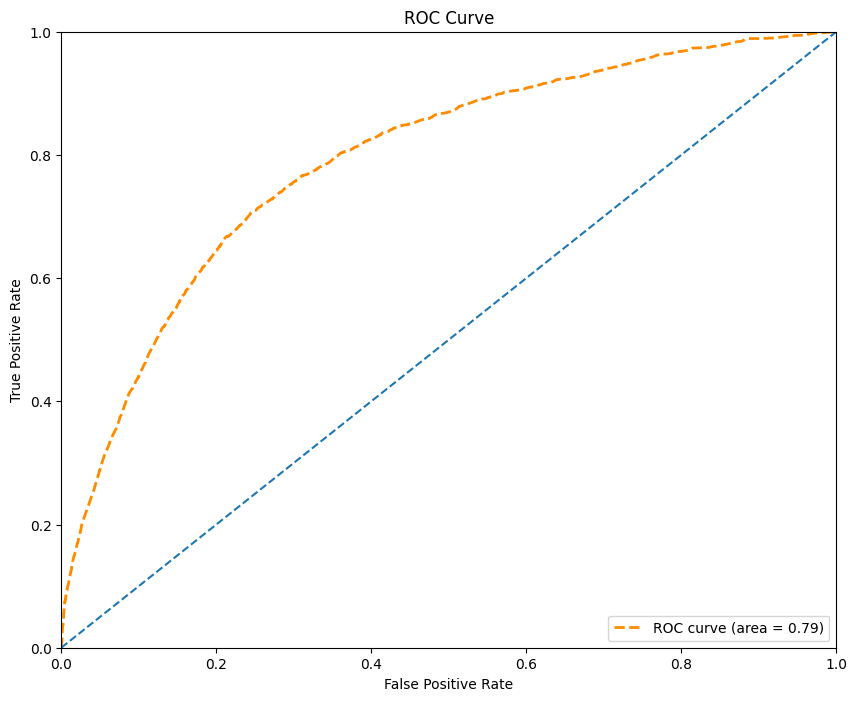

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_prob_test = result.predict_proba(x_test)[:, 1]
fpr, tpr, thres = roc_curve(y_test, y_pred_prob_test)
roc_auc = auc(fpr, tpr)

def _plot_roc_curve(fpr, tpr, thres, auc):
    plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', color='darkorange', lw=2, linestyle='--', label='ROC curve (area = %0.2f)'%auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')

_plot_roc_curve(fpr, tpr, thres, roc_auc)

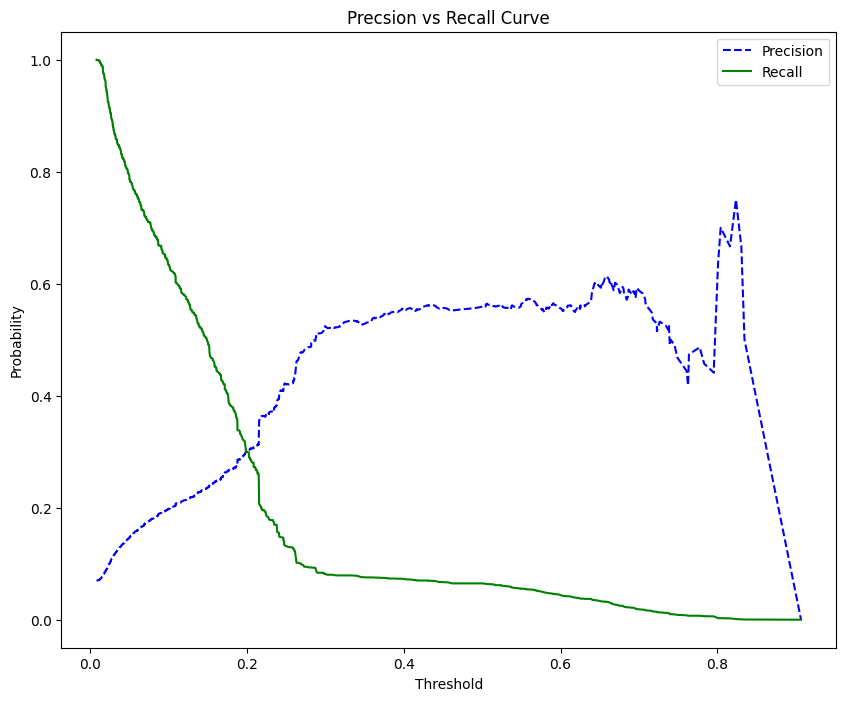

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thres = precision_recall_curve(y_test, y_pred_prob_test)

def _plot_prec_rec_curve(prec, rec, thres):
    plt.figure(figsize = (10, 8))
    plt.plot(thres, prec[:-1], 'b--', label = 'Precision')
    plt.plot(thres, rec[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title('Precsion vs Recall Curve')
    plt.legend()

_plot_prec_rec_curve(precision, recall, thres)

In [ ]:
def _KM(y_pred, n_bins):
  _, thresholds = pd.qcut(y_pred, q=n_bins, retbins=True)
  cmd_BAD = []
  cmd_GOOD = []
  BAD_id = set(np.where(y_test == 0)[0])
  GOOD_id = set(np.where(y_test == 1)[0])
  total_BAD = len(BAD_id)
  total_GOOD = len(GOOD_id)
  for thres in thresholds:
    pred_id = set(np.where(y_pred <= thres)[0])
    # Đếm % số lượng hồ sơ BAD có xác suất dự báo nhỏ hơn hoặc bằng thres
    per_BAD = len(pred_id.intersection(BAD_id))/total_BAD
    cmd_BAD.append(per_BAD)
    # Đếm % số lượng hồ sơ GOOD có xác suất dự báo nhỏ hơn hoặc bằng thres
    per_GOOD = len(pred_id.intersection(GOOD_id))/total_GOOD
    cmd_GOOD.append(per_GOOD)
  cmd_BAD = np.array(cmd_BAD)
  cmd_GOOD = np.array(cmd_GOOD)
  return cmd_BAD, cmd_GOOD, thresholds

cmd_BAD, cmd_GOOD, thresholds = _KM(y_pred_prob_test, n_bins=20)

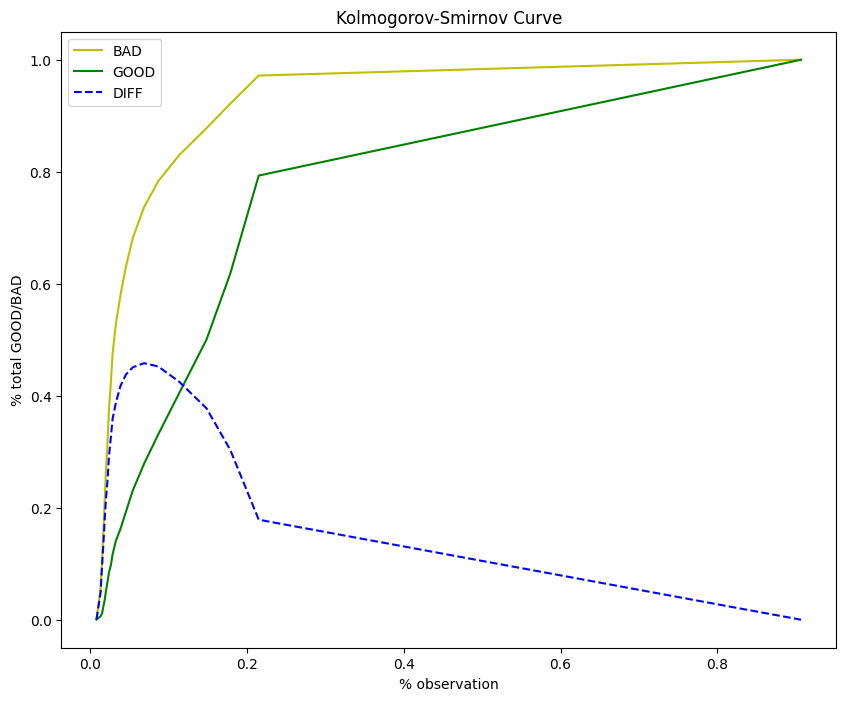

In [ ]:
def _plot_KM(cmd_BAD, cmd_GOOD, thresholds):
  plt.figure(figsize = (10, 8))
  plt.plot(thresholds, cmd_BAD, 'y-', label = 'BAD')
  plt.plot(thresholds, cmd_GOOD, 'g-', label = 'GOOD')
  plt.plot(thresholds, cmd_BAD-cmd_GOOD, 'b--', label = 'DIFF')
  plt.xlabel('% observation')
  plt.ylabel('% total GOOD/BAD')
  plt.title('Kolmogorov-Smirnov Curve')
  plt.legend()

_plot_KM(cmd_BAD, cmd_GOOD, thresholds)

In [ ]:
from scipy import stats

stats.ks_2samp(cmd_BAD, cmd_GOOD)



KstestResult(statistic=0.42857142857142855, pvalue=0.041088503979639056, statistic_location=0.1930379746835443, statistic_sign=-1)